This is the script how to use Joint/Stage-wise discretization  

Note: Joint discretization is super fast than stage-wise.

Assume $j$ is the best cut point set in $j$th iteration, we could find another cut point ${t_{j+1}}$ to reach maximum MI or minimum P_value.  
We define sample size $n$, number of predictors $p$ and $k$ selected variables.
Time complexity of joint discretization:
* $\argmax(I(X_{j+1};Y) - I(X_{j};Y)) \rightarrow O(npk)$
* $\argmin(P(I(X_{j+1};Y) - I(X_{j};Y))) \rightarrow O(npk)$

Furthermore, we could further decrese the time complexity to $O(npl)$, where $l$ is the unique selected variable of $k$.

In [2]:
from efficientVariableSelection import VariableSelection
import numpy as np
from scipy.special import softmax
from sklearn.base import clone

class Problem:

    @staticmethod
    def randomSparseProblem(p, r, k, random_state=None):
        RNG = np.random.default_rng(seed=random_state)
        beta_prime = RNG.multivariate_normal(mean=np.zeros(r), cov=np.eye(r), size=k)
        relevant = RNG.choice(p, r, replace=False)
        beta = np.zeros(shape=(k,p))
        beta[:, relevant] = beta_prime
        return Problem(beta, relevant)

    def __init__(self, beta, relevant):
        self.beta = beta
        self.relevant = relevant
        self.k, self.p = self.beta.shape

    def rvs(self, n, random_state=None):
        RNG = np.random.default_rng(seed=random_state)
        x = RNG.multivariate_normal(mean=np.zeros(self.p), cov=np.eye(self.p), size=n)
        probs = softmax(x.dot(self.beta.T), axis=1)
        y = np.array([RNG.multinomial(1, probs[i]) for i in range(n)])
        _, y = np.nonzero(y)
        return x, y


class PrecisionRecallExperiment:

    def __init__(self, problem, reps, ns, methods, names):
        self.problem = problem
        self.reps = reps
        self.ns = ns
        self.methods = methods
        self.names = names

    def run(self):
        self.prec_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.rec_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.num_selected_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.mean_num_cuts_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.max_num_cuts_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))

        for j, n in enumerate(self.ns):
            print('n: ', n)
            for rep in range(self.reps):
                x, y = self.problem.rvs(n)
                for i, method in enumerate(self.methods):
                    selection = clone(method, safe=False)
                    selection.fit(x, y) 
                    intersection = np.intersect1d(selection.selected_, self.problem.relevant)
                    precision = len(intersection)/len(selection.selected_) if len(selection.selected_)>0 else 1.0
                    recall = len(intersection)/len(self.problem.relevant)
                    self.prec_[i, rep, j] = precision
                    self.rec_[i, rep, j] = recall
                    self.num_selected_[i, rep, j] = len(selection.selected_)
                    self.mean_num_cuts_[i, rep, j] = selection.num_cuts_selected_.mean() if len(selection.selected_)>0 else 0.0
                    self.max_num_cuts_[i, rep, j] = selection.num_cuts_selected_.max() if len(selection.selected_)>0 else 0.0
                    print('|', end='')
            print()

k = 5
r, p = 10, 50
problem = Problem.randomSparseProblem(p, r, k, random_state=0)

reps = 10
alpha = 0.16
gamma = 0.4
ns = np.array([50, 100, 200, 400, 800])
names = [#  'multiple bonferroni mi',
         'single bonferroni mi',
        #  'multiple bonferroni p_value',
         'single bonferroni p_value',
        #  'multiple sine mi',
         'single sine mi',
        #  'multiple sine p_value',
         'single sine p_value'
         ]
methods = [
        # VariableSelection(alpha=0.05, base='mi', criteria='bonferroni_duplicate', num_cutpoints=num_cutpoints),
        VariableSelection(alpha=0.05, base='mi', criteria='bonferroni_unique', gamma=gamma),
        # VariableSelection(alpha=0.05, base='p_value', criteria='bonferroni_duplicate', num_cutpoints=num_cutpoints),
        VariableSelection(alpha=0.05, base='p_value', criteria='bonferroni_unique', gamma=gamma),

        # VariableSelection(alpha=0.05, base='mi', criteria='sine_duplicate', num_cutpoints=num_cutpoints),
        VariableSelection(alpha=0.05, base='mi', criteria='sine_unique', gamma=gamma),
        # VariableSelection(alpha=0.05, base='p_value', criteria='sine_duplicate', num_cutpoints=num_cutpoints),
        VariableSelection(alpha=0.05, base='p_value', criteria='sine_unique', gamma=gamma),
]

precision_recall_exp = PrecisionRecallExperiment(problem, reps, ns, methods, names)
precision_recall_exp.run()

n:  50
||||||||||||||||||||||||||||||||||||||||
n:  100
||||||||||||||||||||||||||||||||||||||||
n:  200
||||||||||||||||||||||||||||||||||||||||
n:  400
||||||||||||||||||||||||||||||||||||||||
n:  800
||||||||||||||||||||||||||||||||||||||||


In [1]:
from efficientVariableSelection import VariableSelection
import numpy as np
from data_generator_v2 import dataGenerator

df_X, y, variable_lst, btrue, formula_display, formula_str = dataGenerator(n=200,
                                                    rho = 0.8,
                                                    p = 100,
                                                    r = 10,
                                                    num_terms = 10,
                                                    degree = 5,
                                                    alpha = None,
                                                    beta = 0.5,
                                                    SNR = 10,
                                                    random_state = 0,
                                                    model = 'binomial').sample()

formula_display

/Users/yluu0028/Documents/PhD-master/Discretization/data_generator_v2.py:171: RuntimeWarning: overflow encountered in exp
  mu = 1/(1+ np.exp(-eta))
/Users/yluu0028/Documents/PhD-master/Discretization/data_generator_v2.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  snr = np.sqrt(np.var(mu)/np.mean(v))
/Users/yluu0028/opt/anaconda3/envs/joint_algorithm/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/yluu0028/Documents/PhD-master/Discretization/data_generator_v2.py:171: RuntimeWarning: overflow encountered in exp
  mu = 1/(1+ np.exp(-eta))
/Users/yluu0028/Documents/PhD-master/Discretization/data_generator_v2.py:171: RuntimeWarning: overflow encountered in exp
  mu = 1/(1+ np.exp(-eta))


$$X_{0}^2+X_{7}^2+X_{0}X_{3}X_{5}X_{6}X_{7}+X_{4}^4+X_{0}X_{1}X_{2}^2X_{4}+X_{2}+X_{3}X_{5}X_{8}+X_{0}X_{5}X_{9}+X_{1}^3X_{2}+X_{9}^5$$

In [3]:
from matplotlib import pyplot as plt

def plot_prec_rec_results(experiment):
    _, axs = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True, sharex=True)
    for i in range(len(methods)):
        axs[0].errorbar(ns, experiment.rec_[i, :, :].mean(axis=0), 1.96*experiment.rec_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
        axs[1].errorbar(ns, experiment.prec_[i, :, :].mean(axis=0), 1.96*experiment.prec_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
        axs[2].errorbar(ns, experiment.num_selected_[i, :, :].mean(axis=0), 1.96*experiment.num_selected_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
        axs[3].errorbar(ns, experiment.max_num_cuts_[i, :, :].mean(axis=0), 1.96*experiment.max_num_cuts_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
    for i in range(4):
        axs[i].set_xlabel('$n$')
    axs[0].set_title('recall')
    axs[1].set_title('precision')
    axs[2].set_title('vars selected')
    axs[3].set_title('max cuts per var')
    axs[0].legend()

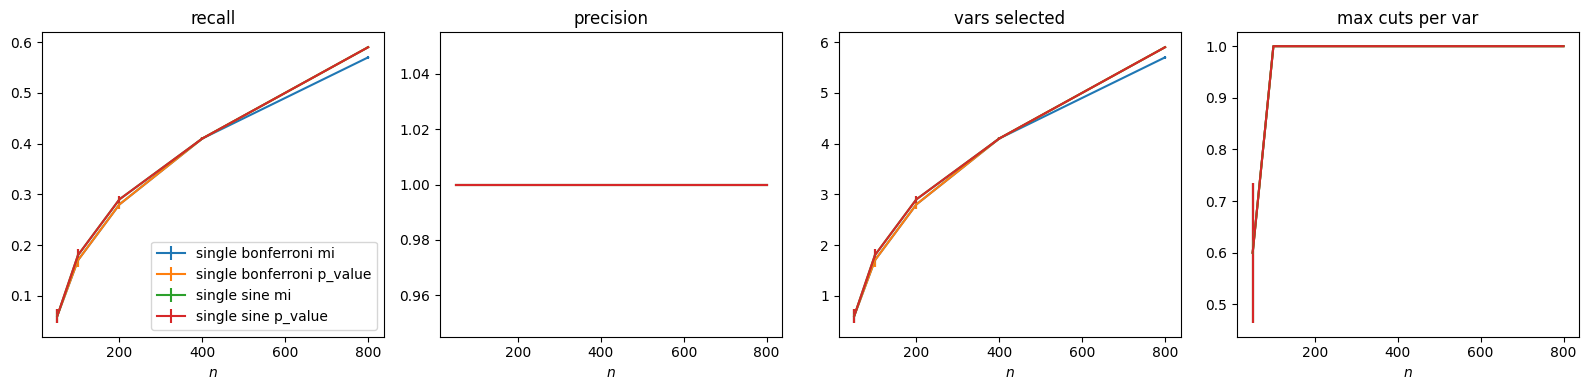

In [4]:
plot_prec_rec_results(precision_recall_exp)
plt.show()

In [2]:
# With maximum MI and no correction alpha
variable_selection_org = VariableSelection(alpha=0.05, base='mi', criteria='Bonferroni_duplicate', gamma=0.4)
variable_selection_org, binnings_org = variable_selection_org.fit(df_X.values, y)
# (dimensions, p-value)
binnings_org.dim_p_value_ , variable_selection_org.selected_ 

In [4]:
# With minimum p_value and no correction alpha
variable_selection_p_value = VariableSelection(alpha=0.05, base='p_value', criteria='Bonferroni_unique', gamma=0.4)
variable_selection_p_value, binnings_p_value = variable_selection_p_value.fit(df_X.values, y)
binnings_p_value.dim_p_value_, variable_selection_p_value.selected_

In [8]:
variable_selection_bonf_p_value = VariableSelection(alpha=0.05, base='p_value', criteria='sine_duplicate', gamma=0.4)
variable_selection_bonf_p_value, binnings_bonf_p_value = variable_selection_bonf_p_value.fit(df_X.values, y)
binnings_bonf_p_value.dim_p_value_, variable_selection_bonf_p_value.selected_

([], array([], dtype=int64))

In [ ]:
variable_selection_bonf_p_value = VariableSelection(alpha=0.05, base='p_value', criteria='sine_unique', gamma=0.4)
variable_selection_bonf_p_value, binnings_bonf_p_value = variable_selection_bonf_p_value.fit(df_X.values, y)
binnings_bonf_p_value.dim_p_value_, variable_selection_bonf_p_value.selected_